 # Pan et al. PromethION reanalysis

In [1]:
import os
import tempfile

import matplotlib.pyplot as plt
import scanpy as sc
import scvi
import torch
import skmisc
import anndata
import numpy as np
scvi.settings.seed = 0
import pandas as pd
import decoupler as dc

import time
import scipy
from scipy import sparse

/home/gennady/miniconda3/envs/scVI/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/gennady/miniconda3/envs/scVI/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/home/gennady/miniconda3/envs/scVI/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/gennady/miniconda3/envs/scVI/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a fu

In [2]:
import pydeseq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats


In [23]:
def scVI_workflow(ad,samplename,sampledir,batch_key='SampleID',n_top_genes=2000,max_epochs=300):
    
    ad.write(f'{sampledir}/{samplename}.h5ad.gz',compression='gzip')
    print(ad.shape)
    try:
        sc.pp.highly_variable_genes(
            ad, flavor="seurat_v3", n_top_genes=n_top_genes, subset=True,batch_key=batch_key)
    except:
        sc.pp.highly_variable_genes(
            ad, flavor="seurat_v3", n_top_genes=n_top_genes, subset=True)
    print(ad.shape)
    scvi.model.SCVI.setup_anndata(ad, layer=None, batch_key=batch_key)
    model = scvi.model.SCVI(ad, n_latent=10, dispersion='gene', gene_likelihood='nb')
    model.train(max_epochs=max_epochs, accelerator='gpu', plan_kwargs={"lr": 5e-3}, check_val_every_n_epoch=10)
    train_elbo = model.history["elbo_train"][1:]
    test_elbo = model.history["elbo_validation"]
    print(ad.shape)
    ax = train_elbo.plot()
    test_elbo.plot(ax=ax)
    Z_hat = model.get_latent_representation()
    model_dir=f'/home/gennady/notebooks/gg2401_sn_13lgs/scvi/{samplename}'
    model.save(model_dir, save_anndata=False)

    SCVI_LATENT_KEY = "X_scVI"
    
    ad.obsm[SCVI_LATENT_KEY] = Z_hat
    sc.pp.neighbors(ad, use_rep=SCVI_LATENT_KEY, n_neighbors=25)
    t1=time.time()
    sc.tl.leiden(ad, key_added="leiden_scVI_02", resolution=0.2)
    sc.tl.leiden(ad, key_added="leiden_scVI_04", resolution=0.4)
    sc.tl.leiden(ad, key_added="leiden_scVI_06", resolution=0.6)
    sc.tl.leiden(ad, key_added="leiden_scVI_08", resolution=0.8)
    sc.tl.leiden(ad, key_added="leiden_scVI_10", resolution=1.0)
    sc.tl.leiden(ad, key_added="leiden_scVI_12", resolution=1.2)
    sc.tl.leiden(ad, key_added="leiden_scVI_14", resolution=1.4)
    t2=time.time()
    print('clustering time: '+str(t2-t1))

    sc.tl.umap(ad, min_dist=0.3)

    ad_allgenes=sc.read_h5ad(f'{sampledir}/{samplename}.h5ad.gz')
    print(ad.shape)
    for key in ad.obs.keys():
        ad_allgenes.obs[key]=ad.obs[key]
    for key in ad.uns.keys():
        ad_allgenes.uns[key]=ad.uns[key]
    for key in ad.obsm.keys():
        ad_allgenes.obsm[key]=ad.obsm[key]
    for key in ad.obsp.keys():
        ad_allgenes.obsp[key]=ad.obsp[key]
    ad=ad_allgenes.copy()
    print(ad.shape)
    ad.write(f'{sampledir}/{samplename}.h5ad.gz',compression='gzip')
    return ad

# Realigned data

Load in realigned Promethion datasets. 

In [3]:
samples_realigned = ['ND245','ND248','ND202','HF373','HF375','HF379','HF380']

In [4]:
ads = []
for sample in samples_realigned:
    samp_dir=f'/home/gennady/curation-results/pan/kb_nac_lr/{sample}_reverse/counts_unfiltered/'
    ad_ = sc.read_mtx(samp_dir+'cells_x_genes.total.mtx')
    bcs = np.loadtxt(samp_dir+'cells_x_genes.barcodes.txt',dtype=str)
    genes = np.loadtxt(samp_dir+'cells_x_genes.genes.names.txt',dtype=str)
    ad_.var.index = genes
    ad_.obs.index = bcs
    ad_.obs['SampleID']=sample
    ads.append(ad_)

In [5]:
ads

[AnnData object with n_obs × n_vars = 686855 × 38606
     obs: 'SampleID',
 AnnData object with n_obs × n_vars = 862121 × 38606
     obs: 'SampleID',
 AnnData object with n_obs × n_vars = 728049 × 38606
     obs: 'SampleID',
 AnnData object with n_obs × n_vars = 541531 × 38606
     obs: 'SampleID',
 AnnData object with n_obs × n_vars = 481386 × 38606
     obs: 'SampleID',
 AnnData object with n_obs × n_vars = 978918 × 38606
     obs: 'SampleID',
 AnnData object with n_obs × n_vars = 790231 × 38606
     obs: 'SampleID']

Perform some initial knee plot filtering.

In [6]:
knees = []
for ad_ in ads:
    knee = np.sort((np.array(ad_.X.sum(axis=1))).flatten())[::-1]
    knees.append(knee)


In [7]:
print(len(samples_realigned))
thrs = [2e2,1e2,2e2,2e2,1e2,2e2,2e2]

7


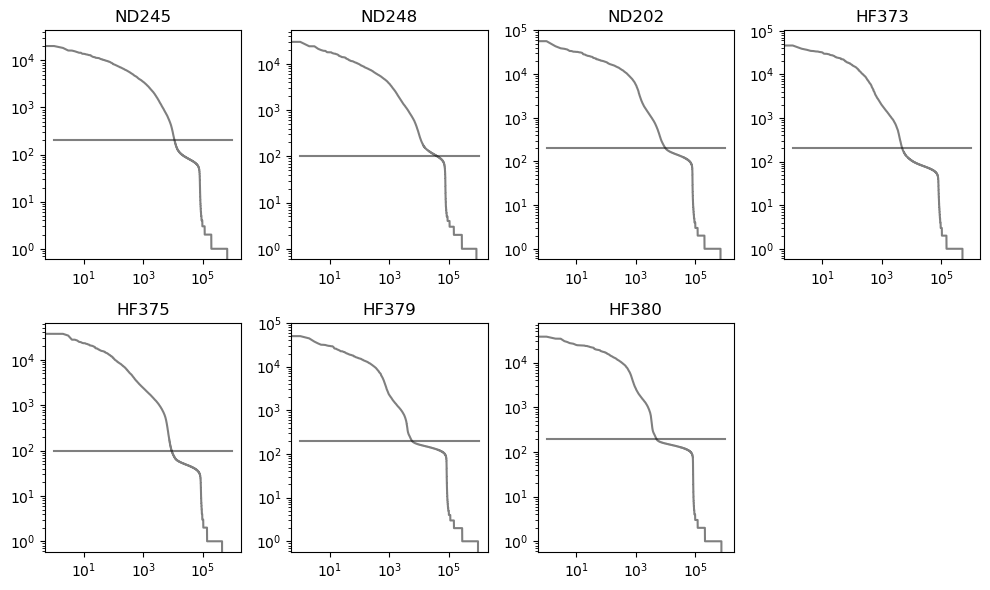

In [8]:
fig1,ax1=plt.subplots(2,4,figsize=(10,6))
for i,sample in enumerate(samples_realigned):
    axl = np.unravel_index(i,(2,4))
    ax1[axl].plot(range(len(knees[i])),knees[i],alpha=0.5,c='k')
    ax1[axl].plot([1,1e6],[thrs[i]]*2,alpha=0.5,c='k')
    ax1[axl].set_title(sample)
    ax1[axl].set_xscale('log')
    ax1[axl].set_yscale('log')
ax1[1,3].remove()
fig1.tight_layout()

In [9]:
for ad_ in ads:
    ad_.obs['total_UMIs']=ad_.X.sum(1)

In [10]:
ads_ = []
for i,ad_ in enumerate(ads):
    ads_.append(ad_[ad_.obs['total_UMIs']>thrs[i]])

In [11]:
ads_

[View of AnnData object with n_obs × n_vars = 11342 × 38606
     obs: 'SampleID', 'total_UMIs',
 View of AnnData object with n_obs × n_vars = 40389 × 38606
     obs: 'SampleID', 'total_UMIs',
 View of AnnData object with n_obs × n_vars = 10047 × 38606
     obs: 'SampleID', 'total_UMIs',
 View of AnnData object with n_obs × n_vars = 4825 × 38606
     obs: 'SampleID', 'total_UMIs',
 View of AnnData object with n_obs × n_vars = 8978 × 38606
     obs: 'SampleID', 'total_UMIs',
 View of AnnData object with n_obs × n_vars = 5687 × 38606
     obs: 'SampleID', 'total_UMIs',
 View of AnnData object with n_obs × n_vars = 4899 × 38606
     obs: 'SampleID', 'total_UMIs']

In [12]:
ad_kb = anndata.concat(ads_,axis=0)
ad_kb.obs['barcode'] = ad_kb.obs.index
ad_kb.obs_names_make_unique()
ad_kb.X=ad_kb.X.astype(int)

/home/gennady/miniconda3/envs/scVI/lib/python3.9/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Load in the disclosed data matrices.

In [13]:
ad=sc.read_h5ad('/home/gennady/curation-results/heart_datasets/pan_promethion_heart/ad_pan_disclosed.h5ad.gz')
ad.obs['barcode'] = ad.obs['Cell ID'].str.split('_').str[1]

/home/gennady/miniconda3/envs/scVI/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Check whether the barcodes match the disclosed ones. 

The first number is the fraction of kb barcodes in the disclosed data. This should be between 10 and 100%, as we would like to be relatively conservative about throwing out empty drops.

The second number is the fraction of disclosed barcodes in the kb data. This should be nearly 100%: we do not want to throw out any barcodes at all (but we may lose some due to slightly different correction procedures).

In [18]:
for sample in samples_realigned:
    print(sample)
    realigned_bcs = ad_kb.obs.query(f'SampleID=="{sample}"')['barcode']
    disclosed_bcs = ad.obs.query(f'SampleID=="{sample}"')['barcode']
    print('\tkb bcs in disclosed:',realigned_bcs.isin(disclosed_bcs).mean())
    print('\tdisclosed bcs in kb:',disclosed_bcs.isin(realigned_bcs).mean())

ND245
	kb bcs in disclosed: 0.4728442955387057
	disclosed bcs in kb: 0.9960995542347697
ND248
	kb bcs in disclosed: 0.12825274208324047
	disclosed bcs in kb: 0.9996140486298727
ND202
	kb bcs in disclosed: 0.18274111675126903
	disclosed bcs in kb: 1.0
HF373
	kb bcs in disclosed: 0.40953367875647667
	disclosed bcs in kb: 0.9909729187562688
HF375
	kb bcs in disclosed: 0.44453107596346625
	disclosed bcs in kb: 0.9989987484355445
HF379
	kb bcs in disclosed: 0.1366273958150167
	disclosed bcs in kb: 1.0
HF380
	kb bcs in disclosed: 0.41539089610124513
	disclosed bcs in kb: 0.99950884086444


In [21]:
ad_kb.obs

,SampleID,total_UMIs,barcode
AAACCCAAGACGGATC,ND245,483.0,AAACCCAAGACGGATC
AAACCCAAGGTAGCAC,ND245,5671.0,AAACCCAAGGTAGCAC
AAACCCAAGTCAAGCG,ND245,3396.0,AAACCCAAGTCAAGCG
AAACCCAAGTCATGGG,ND245,1534.0,AAACCCAAGTCATGGG
AAACCCAAGTGTTCAC,ND245,254.0,AAACCCAAGTGTTCAC
...,...,...,...
TTTGTTGAGCGCCCAT,HF380,239.0,TTTGTTGAGCGCCCAT
TTTGTTGAGGATACGC,HF380,8775.0,TTTGTTGAGGATACGC
TTTGTTGAGGGATCAC,HF380,226.0,TTTGTTGAGGGATCAC
TTTGTTGTCGCTTTAT,HF380,1964.0,TTTGTTGTCGCTTTAT


In [19]:
ad_kb.write_h5ad('/home/gennady/curation-results/pan/ad_kb_251024.h5ad.gz',compression='gzip')

Run through scVI.

(86167, 38606)
(86167, 1000)


/home/gennady/miniconda3/envs/scVI/lib/python3.9/site-packages/lightning/fabric/accelerators/cuda.py:239: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 150/150: 100%|██████████████████████████████████████████████████████████████████████| 150/150 [13:04<00:00,  5.30s/it, v_num=1, train_loss_step=133, train_loss_epoch=113]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 150/150: 100%|██████████████████████████████████████████████████████████████████████| 150/150 [13:04<00:00,  5.23s/it, v_num=1, train_loss_step=133, train_loss_epoch=113]
(86167, 1000)
clustering time: 560.8197038173676
(86167, 1000)
(86167, 38606)


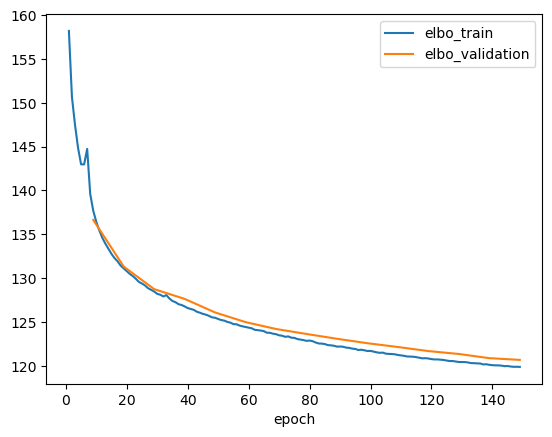

In [24]:
ad_kb_scVI=scVI_workflow(ad_kb.copy(),'gg_251024_pan_promethion_heart_kb',
                         '/home/gennady/curation-results/heart_datasets/pan_promethion_heart/scVI/',batch_key='SampleID',
                     n_top_genes=1000,max_epochs=150)

In [28]:
ad_kb=sc.read_h5ad('/home/gennady/curation-results/heart_datasets/pan_promethion_heart/scVI/gg_251024_pan_promethion_heart_kb.h5ad.gz')

In [30]:
ad_kb.raw=ad_kb.copy()
sc.pp.log1p(ad_kb)

In [31]:
ad_kb.obs['log_total_UMIs']=np.log10(ad_kb.obs['total_UMIs'])

In [32]:
# ad_kb

AnnData object with n_obs × n_vars = 86167 × 38606
    obs: 'SampleID', 'total_UMIs', 'barcode', '_scvi_batch', '_scvi_labels', 'leiden_scVI_02', 'leiden_scVI_04', 'leiden_scVI_06', 'leiden_scVI_08', 'leiden_scVI_10', 'leiden_scVI_12', 'leiden_scVI_14', 'log_total_UMIs'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'leiden', 'neighbors', 'umap', 'log1p'
    obsm: 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

Clearly, cluster 6 is the neurons.

/home/gennady/miniconda3/envs/scVI/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


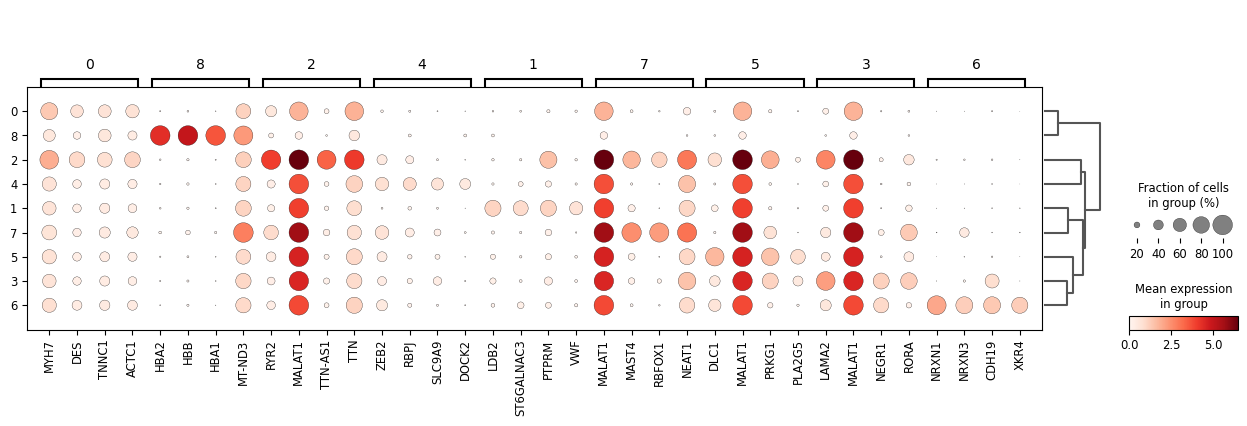

In [83]:
sc.tl.rank_genes_groups(ad_kb, groupby='leiden_scVI_02', groups='all',reference='rest',use_raw=False,method='t-test')
sc.tl.dendrogram(ad_kb,groupby='leiden_scVI_02',use_rep='X_scVI')
sc.pl.rank_genes_groups_dotplot(ad_kb, n_genes=4,use_raw=False)


/home/gennady/miniconda3/envs/scVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/gennady/miniconda3/envs/scVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


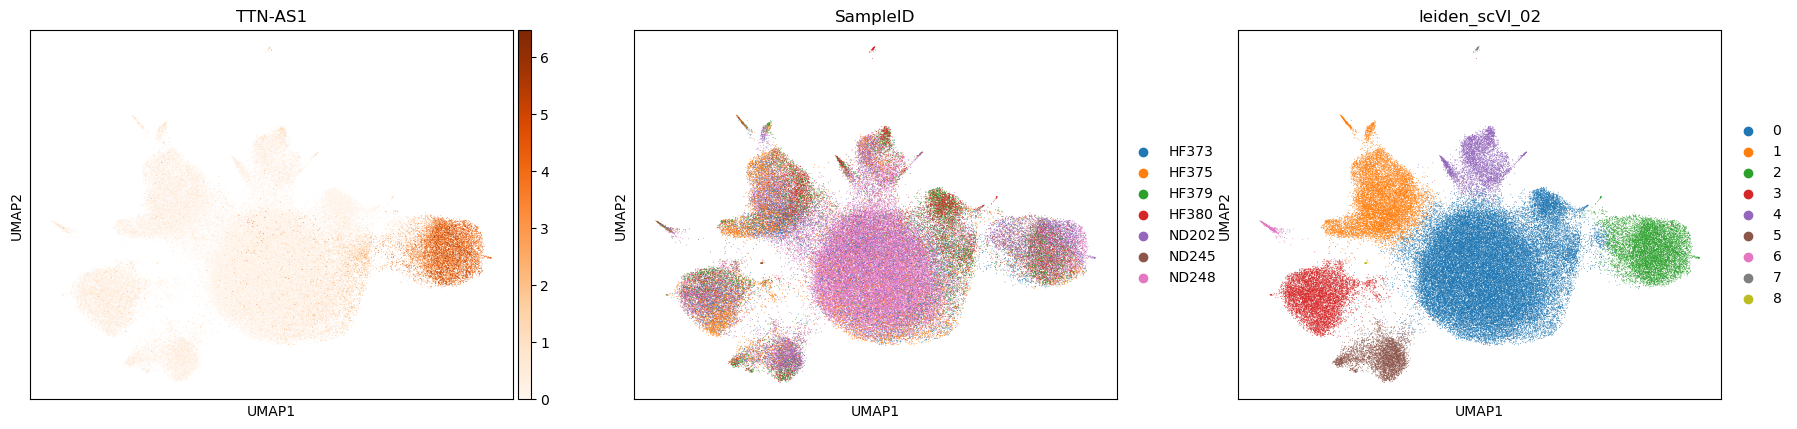

In [85]:
sc.pl.umap(ad_kb,color=['VWF','TTN-AS1','RYR2','SampleID','leiden_scVI_02'],use_raw=False, cmap='Oranges')


/home/gennady/miniconda3/envs/scVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


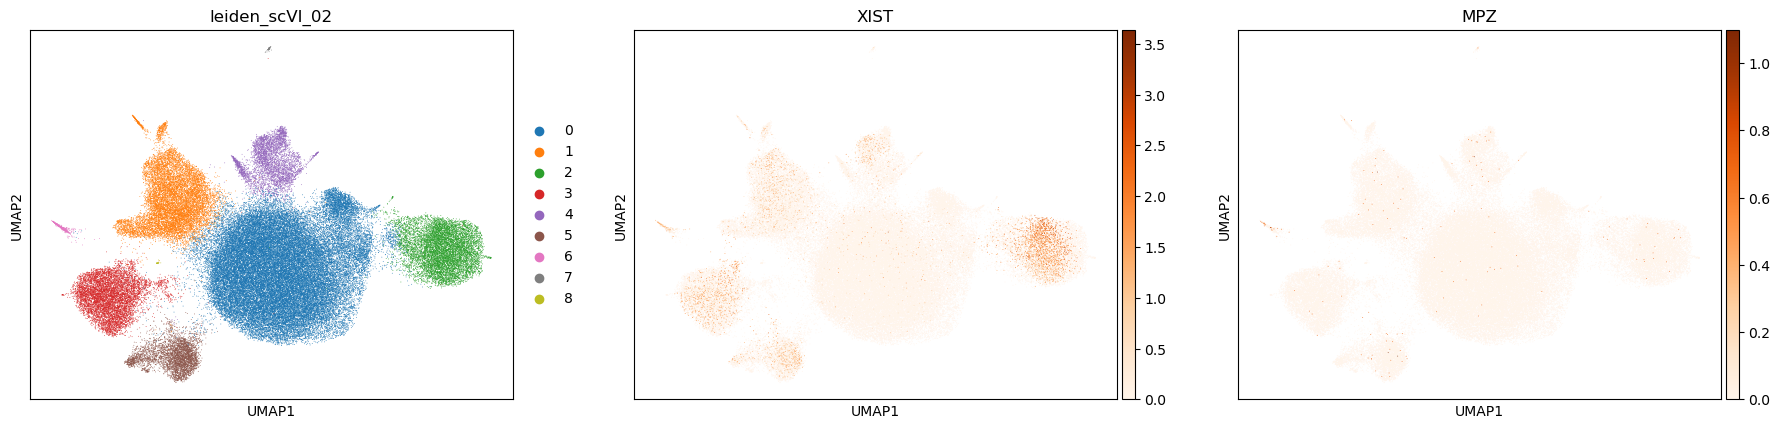

In [33]:
sc.pl.umap(ad_kb,color=['leiden_scVI_02','XIST','MPZ'],cmap='Oranges',use_raw=False)

/home/gennady/miniconda3/envs/scVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/gennady/miniconda3/envs/scVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


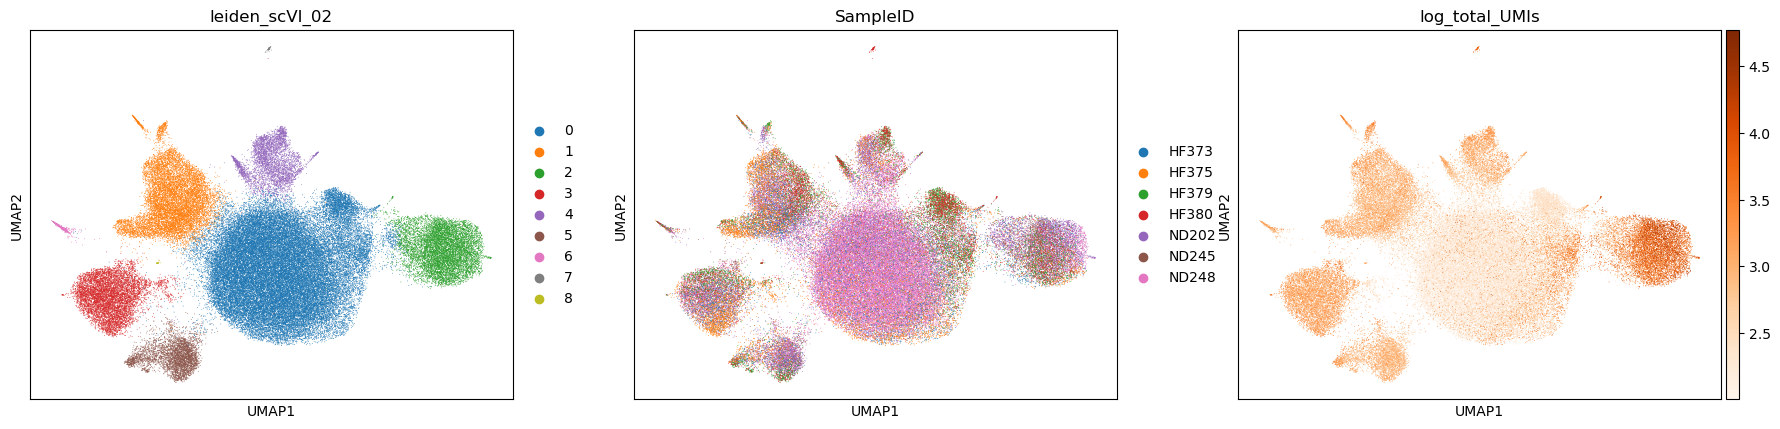

In [35]:
sc.pl.umap(ad_kb,color=['leiden_scVI_02','SampleID','log_total_UMIs'],cmap='Oranges',use_raw=False)

/home/gennady/miniconda3/envs/scVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/gennady/miniconda3/envs/scVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/gennady/miniconda3/envs/scVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


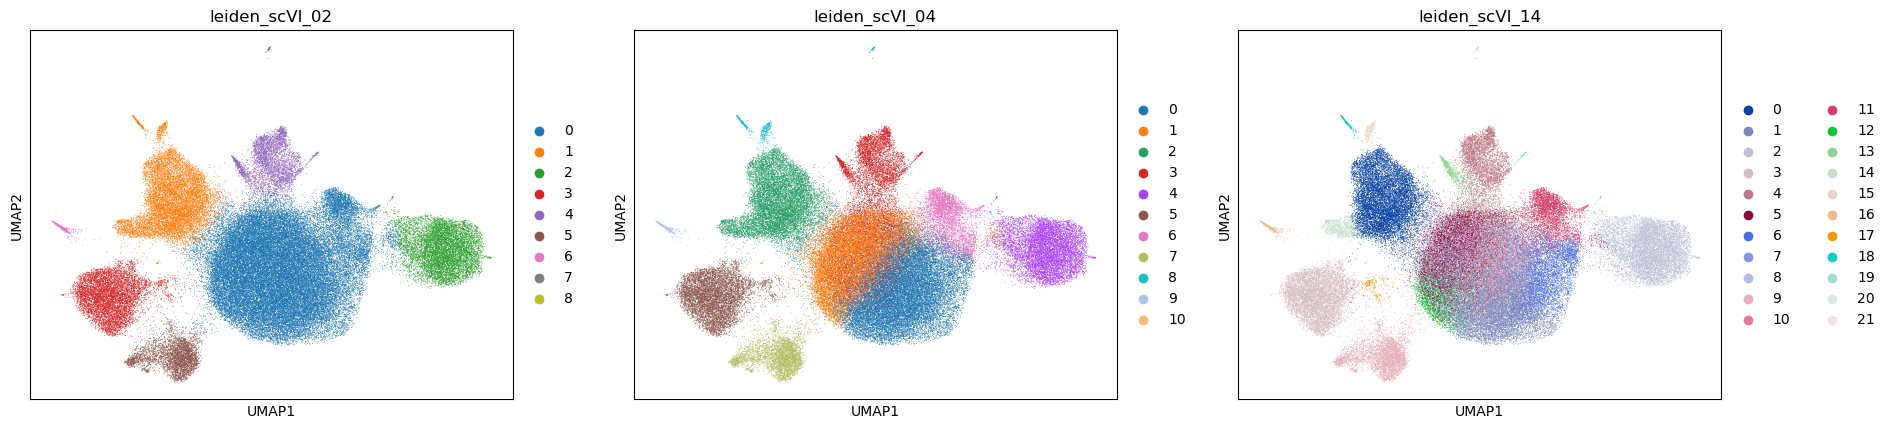

In [36]:
sc.pl.umap(ad_kb,color=['leiden_scVI_02','leiden_scVI_04','leiden_scVI_14'])

For three samples, we recover substantially more neurons than originally disclosed.

In [81]:
# ad.obs['barcode'] = ad.obs.index.str.split('-').str[1]
for sample in samples_realigned:
    print(sample)
    realigned_bcs = ad_kb.obs.query(f'SampleID=="{sample}"  & leiden_scVI_02=="6"')['barcode']
    disclosed_bcs = ad.obs[(ad.obs['SampleID']==sample) & (ad.obs['Cell type']=="Neuronal")]['barcode']
    print('\tdisclosed',len(disclosed_bcs))
    print('\trealigned',len(realigned_bcs))
    print('\tkb bcs in disclosed:',realigned_bcs.isin(disclosed_bcs).mean())
    print('\tdisclosed bcs in kb:',disclosed_bcs.isin(realigned_bcs).mean())


ND245
	disclosed 78
	realigned 71
	kb bcs in disclosed: 0.8028169014084507
	disclosed bcs in kb: 0.7307692307692307
ND248
	disclosed 119
	realigned 136
	kb bcs in disclosed: 0.8308823529411765
	disclosed bcs in kb: 0.9495798319327731
ND202
	disclosed 7
	realigned 65
	kb bcs in disclosed: 0.1076923076923077
	disclosed bcs in kb: 1.0
HF373
	disclosed 10
	realigned 10
	kb bcs in disclosed: 0.9
	disclosed bcs in kb: 0.9
HF375
	disclosed 39
	realigned 37
	kb bcs in disclosed: 0.8648648648648649
	disclosed bcs in kb: 0.8205128205128205
HF379
	disclosed 3
	realigned 28
	kb bcs in disclosed: 0.03571428571428571
	disclosed bcs in kb: 0.3333333333333333
HF380
	disclosed 0
	realigned 17
	kb bcs in disclosed: 0.0
	disclosed bcs in kb: nan


Discard the empty drops so we are not underestimating the non-pseudoglial expression of *XIST*.

In [100]:
ad_kb=ad_kb[ad_kb.obs['leiden_scVI_02']!='0'].copy()

In [93]:
psbulk = dc.get_pseudobulk(ad_kb,sample_col='SampleID',groups_col='leiden_scVI_02',use_raw=True,mode='sum',min_cells=0,
                           min_counts=0,remove_empty=False)
psbulk.obs['XIST'] = psbulk[:,'XIST'].X.toarray().squeeze().astype(int)
psbulk.obs['XIST_mean'] = psbulk.obs['XIST']/psbulk.obs['psbulk_n_cells']

We observe some *XIST* expression in the neuronal cluster.

In [94]:
psbulk.obs.query('leiden_scVI_02=="6"')

,SampleID,_scvi_batch,_scvi_labels,leiden_scVI_02,psbulk_n_cells,psbulk_counts,XIST,XIST_mean
HF373_6,HF373,0,0,6,10.0,14875.0,1,0.100000
HF375_6,HF375,1,0,6,37.0,27925.0,6,0.162162
HF379_6,HF379,2,0,6,28.0,32995.0,14,0.500000
HF380_6,HF380,3,0,6,17.0,31522.0,1,0.058824
ND202_6,ND202,4,0,6,65.0,56795.0,14,0.215385
ND245_6,ND245,5,0,6,71.0,70008.0,100,1.408451
ND248_6,ND248,6,0,6,136.0,100279.0,29,0.213235


In [95]:
psbulk.obs.query('leiden_scVI_02=="6"').psbulk_n_cells.sum()

364.0

The *XIST* expression is substantially higher in the pseudo-glia than in all other cells.

In [102]:
for sample in samples_realigned:
    print(sample,
          ad_kb.raw[ad_kb.obs['SampleID'].isin([sample]) & (ad_kb.obs['leiden_scVI_02']=='6'),'XIST'].X.mean(),
          ad_kb.raw[ad_kb.obs['SampleID'].isin([sample]) & (ad_kb.obs['leiden_scVI_02']!='6'),'XIST'].X.mean())

ND245 1.408450704225352 1.8745559230674995
ND248 0.21323529411764702 0.0029694738092410017
ND202 0.2153846153846154 0.0007822277847309136
HF373 0.1 0.0
HF375 0.16216216216216217 0.00017409470752089137
HF379 0.5 0.007766387076731904
HF380 0.058823529411764705 0.0006837606837606838


Here, we construct whole-sample pseudobulks. By comparing with the table above, the *XIST* expression is predominantly in the pseudoglia in the males: the pseudoglial cell type is very small, but accounts for a large fraction of the expression (e.g., 14/39 UMIs in HF379, while the cell counts are 28/3247).

Out of interest, we can alos check the expression of *TTN-AS1*, which was very low in the reported data. With a stranded alignment strategy, we see considerable amounts of this antisense transcript.

In [103]:
psbulk_glob = dc.get_pseudobulk(ad_kb,sample_col='SampleID',groups_col=None,use_raw=True,mode='sum',min_cells=0,
                           min_counts=0,remove_empty=False)
psbulk_glob.obs['XIST'] = psbulk_glob[:,'XIST'].X.toarray().squeeze().astype(int)
psbulk_glob.obs['TTN'] = psbulk_glob[:,'TTN'].X.toarray().squeeze().astype(int)
psbulk_glob.obs['TTN-AS1'] = psbulk_glob[:,'TTN-AS1'].X.toarray().squeeze().astype(int)

In [104]:
psbulk_glob.obs

,SampleID,_scvi_batch,_scvi_labels,psbulk_n_cells,psbulk_counts,XIST,TTN,TTN-AS1
HF373,HF373,0,0,2643.0,5937610.0,1,58768,21367
HF375,HF375,1,0,5781.0,9679405.0,7,54632,23451
HF379,HF379,2,0,3247.0,9939979.0,39,154340,128626
HF380,HF380,3,0,2942.0,10412918.0,3,183854,109193
ND202,ND202,4,0,6457.0,18474036.0,19,164392,73991
ND245,ND245,5,0,8234.0,13427315.0,15402,184226,72099
ND248,ND248,6,0,8555.0,13655749.0,54,194775,70917


/home/gennady/miniconda3/envs/scVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


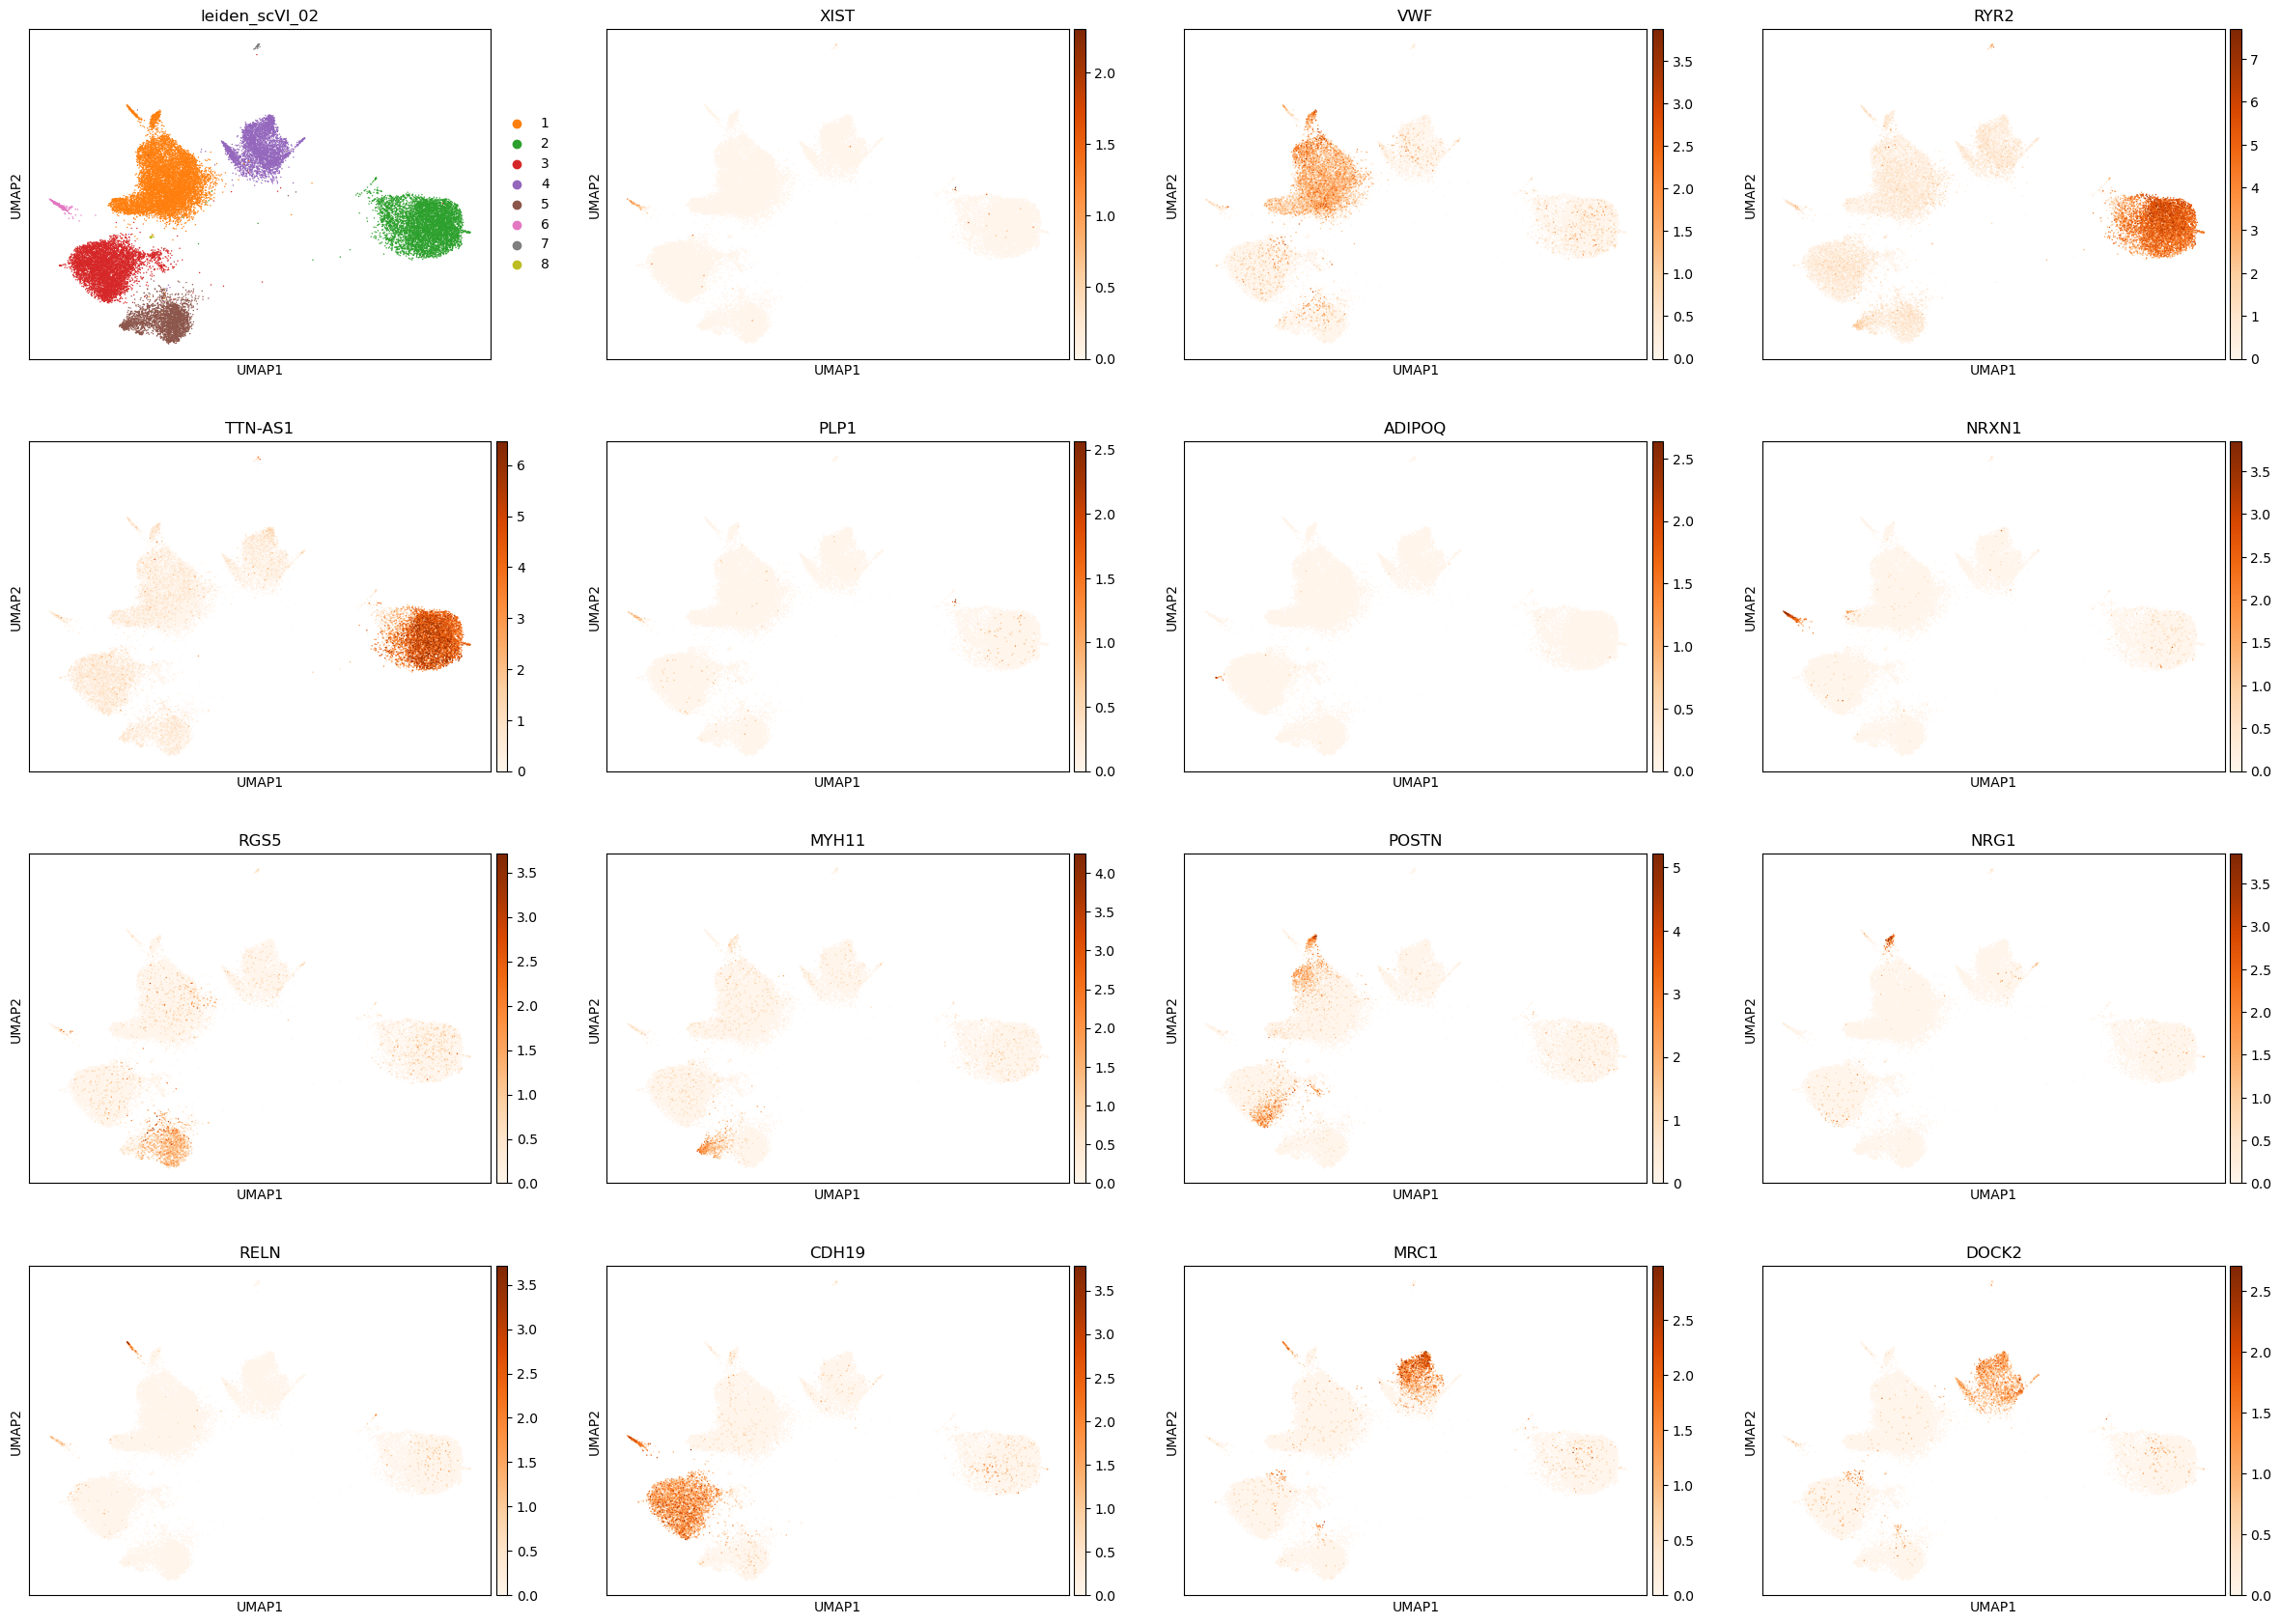

In [108]:
sc.pl.umap(ad_kb[ad_kb.obs['SampleID']!='ND245'],color=['leiden_scVI_02','XIST','VWF','RYR2',
                                                        'TTN-AS1','PLP1','ADIPOQ','NRXN1','RGS5',
                                                        'MYH11','POSTN','NRG1','RELN',
                                                        'CDH19','MRC1','DOCK2'],cmap='Oranges',use_raw=False)

In [131]:
samples_realigned

['ND245', 'ND248', 'ND202', 'HF373', 'HF375', 'HF379', 'HF380']

In [133]:
for sample in samples_realigned:
    ad_kb.obs.query(f'SampleID=="{sample}" & leiden_scVI_02=="6"').barcode.to_csv(
        f'/home/gennady/curation-results/pan/pseudoglial_whitelists_kb/{sample}.txt',
        header=None,index=None)

# DESeq2

We can also check whether the *XIST* expression is higher in the HF donors relative to non-diseased donors. But with $n=2$ vs $n=4$, with very low cell counts, this is not a very informative exercise. 

In [114]:
psbulk_deseq = psbulk[(psbulk.obs['leiden_scVI_02'] == '6') & (psbulk.obs['SampleID']!='ND245')].copy()

In [119]:
psbulk_deseq.obs['pathology'] = psbulk_deseq.obs['SampleID'].str[:2]

In [123]:
psbulk_deseq.obs

,SampleID,_scvi_batch,_scvi_labels,leiden_scVI_02,psbulk_n_cells,psbulk_counts,XIST,XIST_mean,pathology
HF373_6,HF373,0,0,6,10.0,14875.0,1,0.100000,HF
HF375_6,HF375,1,0,6,37.0,27925.0,6,0.162162,HF
HF379_6,HF379,2,0,6,28.0,32995.0,14,0.500000,HF
HF380_6,HF380,3,0,6,17.0,31522.0,1,0.058824,HF
ND202_6,ND202,4,0,6,65.0,56795.0,14,0.215385,ND
ND248_6,ND248,6,0,6,136.0,100279.0,29,0.213235,ND


In [125]:
inference = DefaultInference(n_cpus=8)
dds = DeseqDataSet(
    adata=psbulk_deseq.copy(),
    design_factors=['pathology'],
    refit_cooks=True,
    inference=inference,
    quiet=True)
dds.deseq2()
stat_res_Y_vs_X = DeseqStats(dds, contrast=["pathology", "HF", "ND"], inference=inference,quiet=True)
stat_res_Y_vs_X.summary()
res = stat_res_Y_vs_X.results_df
# res.to_csv(dedir+'gg_250821_linna_kuosmanen_comorbidities_p.csv')


Log2 fold change & Wald test p-value: pathology HF vs ND
               baseMean  log2FoldChange     lfcSE      stat    pvalue  \
A1BG           0.483937       -0.891005  2.588697 -0.344191  0.730703   
A1BG-AS1       1.091081        0.567588  1.784152  0.318128  0.750388   
A1CF           0.000000             NaN       NaN       NaN       NaN   
A2M           13.634529        0.474005  0.896718  0.528600  0.597083   
A2M-AS1        0.000000             NaN       NaN       NaN       NaN   
...                 ...             ...       ...       ...       ...   
ZYX            0.835158        0.538070  1.902974  0.282752  0.777367   
ZZEF1          2.647638       -0.610239  1.179230 -0.517490  0.604814   
ZZZ3           5.074222       -0.566910  0.859916 -0.659262  0.509728   
hsa-mir-1253   0.000000             NaN       NaN       NaN       NaN   
hsa-mir-423    0.000000             NaN       NaN       NaN       NaN   

                  padj  
A1BG          0.992144  
A1BG-AS1      0.

Indeed, the expression is slightly lower in the HF patients. However, the $p$-value is around 0.6, so the test is not informative. Note also that the HF datasets have much smaller cell counts.

In [127]:
res.loc[['XIST']]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
XIST,7.900445,-0.407501,0.859066,-0.474353,0.635248,0.992144
